In [1]:
%pip install pip install opencv-contrib-python numpy matplotlib torch torchvision scikit-image

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement install (from versions: none)
ERROR: No matching distribution found for install

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [79]:
from glob import glob
# os.makedirs("dataset/low_res", exist_ok=True)
# os.makedirs("dataset/high_res", exist_ok=True)

source_folder = "source_images/"
low_folder = "degraded_images/"
output_folder = "output_images/"

In [80]:

from glob import glob

def prepare_dataset(scale=2):
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']

    for ext in image_extensions:
        for path in glob(os.path.join(source_folder, ext)):
            img = cv2.imread(path)
            if img is None:
                continue

            name = os.path.basename(path)

            h, w = img.shape[:2]
            new_w = w // scale
            new_h = h // scale

            degraded = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            degraded = cv2.resize(degraded, (w, h), interpolation=cv2.INTER_LINEAR)

            cv2.imwrite(os.path.join(low_folder, name), degraded)

            print(f"Saved degraded version of {name}")


In [81]:
# prepare_dataset()

Approach 1: Nearest-Neighbor Interpolation + Gaussian Filter

1. Fastest interpolation method (nearest-neighbor).
2. Gaussian filter is used to smooth the artifacts from interpolation.


In [82]:
def gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 1)

def upscale_nn_gaussian(img):
    upscaled = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
    return gaussian_blur(upscaled)

Approach 2: Bicubic Interpolation + Bilateral Filter

1. We use bicubic interpolation for better quality than nearest.
2. We apply bilateral filter to smooth noise while preserving edges.

In [83]:
def bilateral_filter(image):
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def upscale_bicubic_bilateral(img):
    upscaled = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return bilateral_filter(upscaled)

Approach 3: Lanczos Interpolation + Guided Filter + Sharpening

1. We use "Lanczos interpolation" because it is the best among classic methods.
2. We apply guided filter to preserve structure.
3. We use sharpening kernel to enhance edges.

In [84]:
# %pip uninstall opencv-python
# %pip install opencv-contrib-python

In [85]:
import cv2
print(hasattr(cv2.ximgproc, "guidedFilter"))

True


In [86]:
# import cv2
import cv2.ximgproc

def sharpen(image):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def guided_filter(img, radius=5, eps=1e-2):
    import cv2.ximgproc  # requires opencv-contrib-python
    filtered = cv2.ximgproc.guidedFilter(guide=img, src=img, radius=radius, eps=eps)
    return filtered

def upscale_lanczos_guided_sharp(img):
    upscaled = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LANCZOS4)
    guided = guided_filter(upscaled)
    return sharpen(guided)

In [87]:
def evaluate(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    return psnr(img1, img2), ssim(img1, img2)

In [88]:
img1 = cv2.imread('source_images/BrBa.jpg')
img2 = cv2.imread('down_images/BrBa.jpg')
evaluate(img1, img2)

(np.float64(30.71286390007146), np.float64(0.8640500065080082))

In [89]:
approaches = {
    "Nearest + Gaussian": upscale_nn_gaussian,
    "Bicubic + Bilateral": upscale_bicubic_bilateral,
    "Lanczos + Guided + Sharpen": upscale_lanczos_guided_sharp
}

In [93]:
import time

results = {}

for name, func in approaches.items():
    print(f"\n Running: {name}")

    psnrs, ssims = [], []
    approach_output_dir = os.path.join(output_folder, name.replace(" ", "_"))
    os.makedirs(approach_output_dir, exist_ok=True)

    start_time = time.time()

    for img_name in os.listdir(low_folder):
        low_path = os.path.join(low_folder, img_name)
        high_path = os.path.join(source_folder, img_name)

        low = cv2.imread(low_path)
        high = cv2.imread(high_path)

        if low is None or high is None:
            print(f" Skipping {img_name} (couldn't load)")
            continue

        output = func(low)

        # Ensure output matches target size
        output = cv2.resize(output, (high.shape[1], high.shape[0]), interpolation=cv2.INTER_CUBIC)

        # Save enhanced image
        output_path = os.path.join(approach_output_dir, img_name)
        cv2.imwrite(output_path, output)

        p, s = evaluate(output, high)
        psnrs.append(p)
        ssims.append(s)

    duration = time.time() - start_time
    results[name] = {
        "PSNR": np.mean(psnrs),
        "SSIM": np.mean(ssims),
        "Time": duration
    }

# Final summary
print("\n Final Evaluation Summary:")
for name, metrics in results.items():
    print(f"\n{name}")
    print(f"Avg PSNR : {metrics['PSNR']:.2f}")
    print(f"Avg SSIM : {metrics['SSIM']:.4f}")
    print(f"Time Taken: {metrics['Time']:.2f} seconds")


 Running: Nearest + Gaussian

 Running: Bicubic + Bilateral

 Running: Lanczos + Guided + Sharpen

 Final Evaluation Summary:

Nearest + Gaussian
Avg PSNR : 28.58
Avg SSIM : 0.8693
Time Taken: 1.83 seconds

Bicubic + Bilateral
Avg PSNR : 28.42
Avg SSIM : 0.8491
Time Taken: 3.30 seconds

Lanczos + Guided + Sharpen
Avg PSNR : 28.84
Avg SSIM : 0.8963
Time Taken: 5.19 seconds


In [94]:
sample_images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:2]

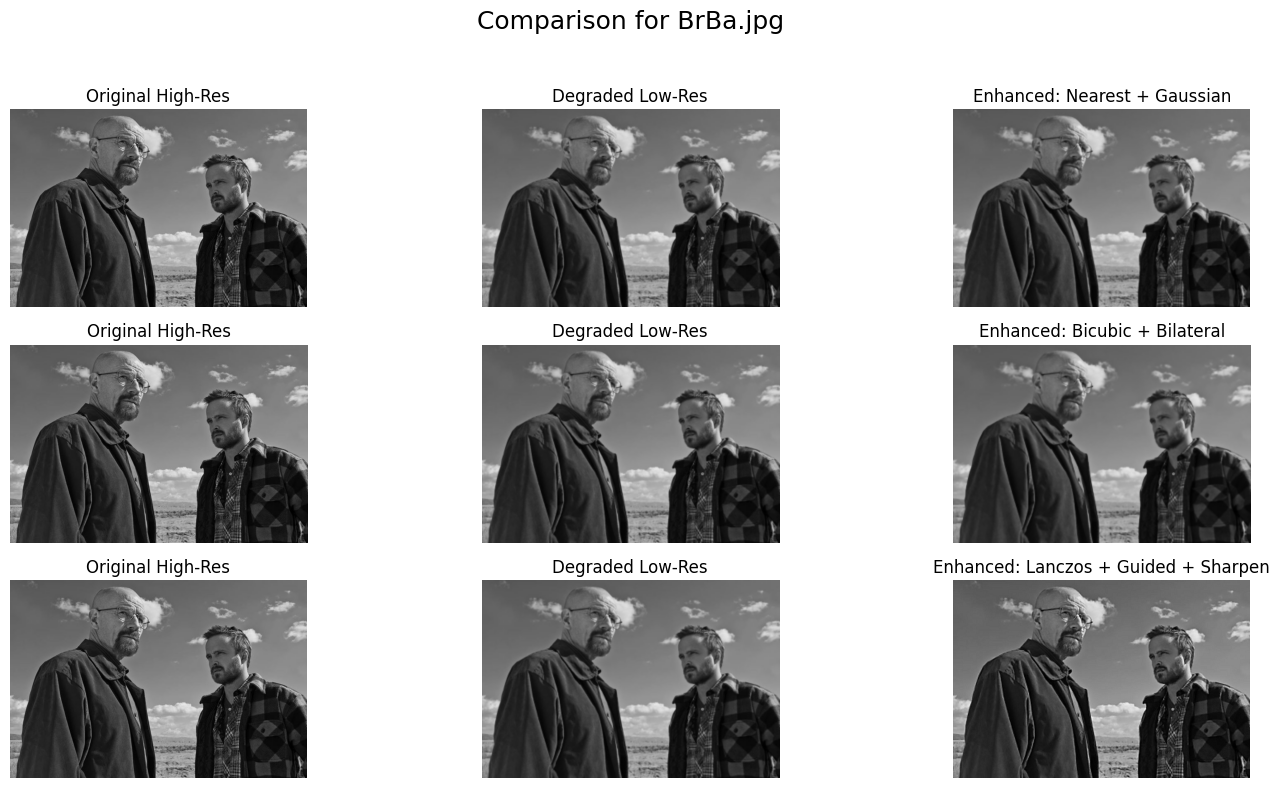

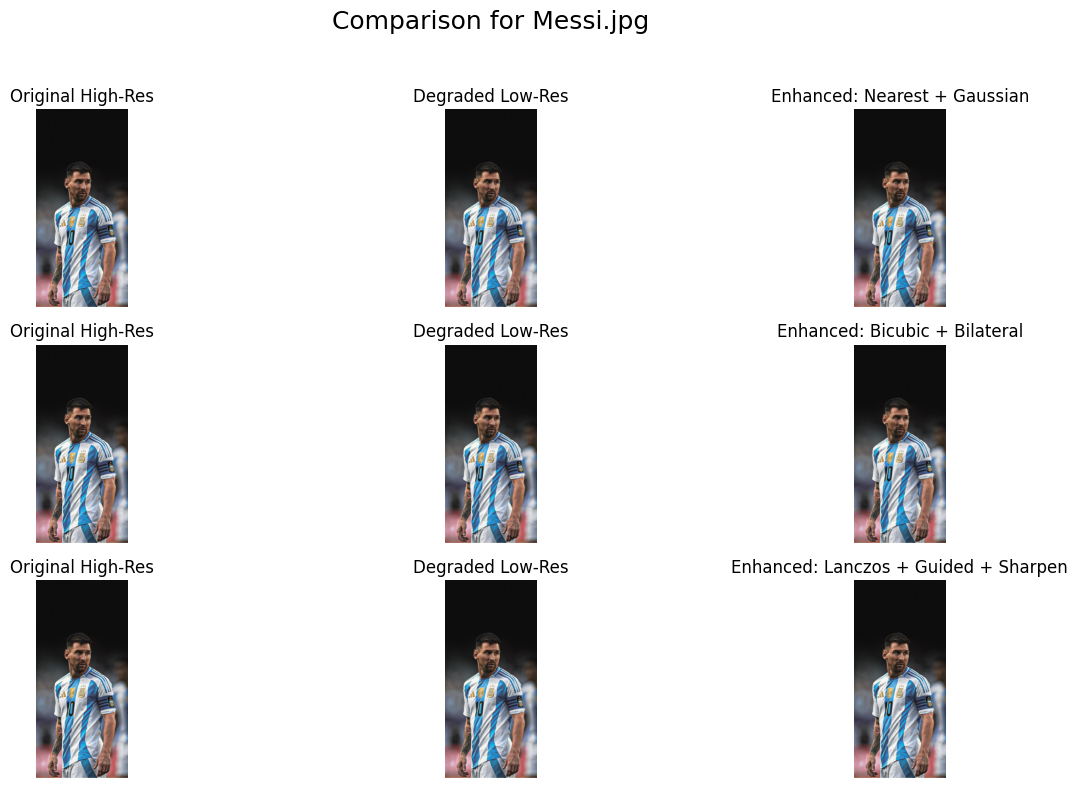

In [95]:
for img_name in sample_images:
    fig, axs = plt.subplots(len(approaches), 3, figsize=(15, 8))
    fig.suptitle(f"Comparison for {img_name}", fontsize=18)

    # Load high-res and low-res versions
    high_img = cv2.imread(os.path.join(source_folder, img_name))
    low_img = cv2.imread(os.path.join(low_folder, img_name))

    # Convert BGR to RGB for visualization
    high_img = cv2.cvtColor(high_img, cv2.COLOR_BGR2RGB)
    low_img = cv2.cvtColor(low_img, cv2.COLOR_BGR2RGB)

    for i, (approach_name, _) in enumerate(approaches.items()):
        output_path = os.path.join(output_folder, approach_name.replace(" ", "_"), img_name)

        if not os.path.exists(output_path):
            print(f"⚠️ Output not found for: {approach_name} - {img_name}")
            continue

        output_img = cv2.imread(output_path)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

        axs[i, 0].imshow(high_img)
        axs[i, 0].set_title("Original High-Res")

        axs[i, 1].imshow(low_img)
        axs[i, 1].set_title("Degraded Low-Res")

        axs[i, 2].imshow(output_img)
        axs[i, 2].set_title(f"Enhanced: {approach_name}")

        for j in range(3):
            axs[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()